In [1]:
import pandas as pd
import importlib

In [2]:
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/PoreC_Fibroblasts/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}neonatal_fragsOutput_byChr/neonatal_fibroblasts_chr2.gz'
colnames = ["chr","start","end","readID","readLen","readQual",
"geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist","ID"]

fullBed = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

In [3]:
chr19 = fullBed[fullBed['chr']=="chr2"]
binSize = 1*10**6 #5*10**5
chrBins = [x for x in range(0,chromSizes['chr2']+binSize,binSize)]
chr19_binned = pd.cut(chr19['start'],bins = chrBins, labels = ["Bin"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
chr19_wBinID = chr19.merge(chr19_binned,left_index=True,right_index=True)

In [4]:
chr19_wBinID[['ID','binID']].tail()

,ID,binID
612155,382207,Bin242
612156,382208,Bin242
612157,382045,Bin243
612158,382209,Bin243
612159,382210,Bin243


In [58]:
groupedBins = chr19_wBinID.groupby('ID')['binID'].apply(list).reset_index(name='Bins')

In [59]:
def sort_key(item):
    return int(item.split('Bin')[1])

edges = ["_".join(sorted(list(set(a)), key=sort_key)) for a in groupedBins['Bins'] if len(list(set(a))) > 1]
readIDs = [groupedBins.iloc[ix][0] for ix in range(len(groupedBins)) if len(list(set(groupedBins.iloc[ix][1]))) > 1]
print(len(edges))
print(len(readIDs))

105355
105355


In [60]:
from collections import Counter
edgeDict = dict(Counter(edges))


In [73]:
len(edgeDict.keys())

57618

In [62]:
import pickle

with open(f'{dataDir}adult_chr2_dict.pkl','wb') as f:
    pickle.dump(edgeDict,f)

In [6]:
import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from promethData_multiwayExpectedProbs import multiwayEval_realData


In [50]:
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/PoreC_Fibroblasts/'
runDir = 'v1.evaluateExpectedVersusInteresting_adult/'
plotDir = f'{dataDir}{runDir}Plots_adult_chr2/'
outDir = f'{dataDir}{runDir}dfs_adult_chr2/'
inputPkl = 'adult_chr2_dict.pkl'
probHashOutName = f'{outDir}probHash_chr2.json'

seed = 1
quartile = 25
toChoose = 400
toPlotRef = False
toPlotInd = False
toPlotScatter = False

In [51]:
import os
import json
import warnings
import pickle

print("Loading in hyperedge pickle file")
with open(f'{dataDir}/{inputPkl}','rb') as f:
    hpEdges = pickle.load(f)

print("Processing all the hyperedges from pickle file")
hpKeys = [k for k in hpEdges.keys()]
print("A total of",len(hpKeys),"initial interactions")

readSupport = [v for v in hpEdges.values()]
atLeastTwoChains = [i for i,x in enumerate(readSupport) if x >=2]
updatedDict = {hpKeys[i]:readSupport[i] for i in atLeastTwoChains}

hpKeys = [k for k in updatedDict.keys()]
hpKeys_split = [k.split("_") for k in updatedDict.keys()]
keyCard = [len(item) for item in hpKeys_split]

print("Updated the input: retaining",len(hpKeys),
        "interactions with chain support of at least 2")

evalInstance = multiwayEval_realData(keyCard, updatedDict, hpKeys, hpKeys_split, seed,
                            toChoose, toPlotRef, toPlotInd, toPlotScatter,
                            quartile, plotDir,outDir)

if os.path.exists(probHashOutName):
    print("Expected probabilities file already exists...moving on")
    with open(probHashOutName,'r') as file:
        tmpHash = json.load(file)
        # probHash = {key: {int(k): v for k, v in value.items() if value is not None} 
        #             if value is not None else None for key, value in tmpHash.items()}
        probHash = {key: {int(k): v for k, v in value.items()} for key, value in tmpHash.items() if value is not None}

else:
    print("Expected probabilities file does not exist...creating now")
    probHash = evalInstance.makeAllReferenceHashDicts()
    with open(probHashOutName,'w') as file:
        json.dump(probHash,file)
    print("File created...moving on")

warnings.filterwarnings('ignore')


Loading in hyperedge pickle file
Processing all the hyperedges from pickle file
A total of 57618 initial interactions
Updated the input: retaining 16581 interactions with chain support of at least 2
Expected probabilities file does not exist...creating now
Calculating for card= 8
There are  2 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Creating a probability hash for 7-way subsets
Calculating for card= 7
There are  1 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Calculating for card= 6
There are  4 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a proba

In [28]:
evalInstance = multiwayEval_realData(keyCard, updatedDict, hpKeys, hpKeys_split, seed,
                            toChoose, toPlotRef, toPlotInd, toPlotScatter,
                            quartile, plotDir,outDir)

In [30]:
from collections import Counter
# dict(Counter(keyCard))

In [52]:
import importlib
import promethData_multiwayExpectedProbs
importlib.reload(promethData_multiwayExpectedProbs)

from promethData_multiwayExpectedProbs import multiwayEval_realData

In [53]:
toChoose = 1000

evalInstance = multiwayEval_realData(keyCard, updatedDict, hpKeys, hpKeys_split, seed,
                            toChoose, toPlotRef, toPlotInd, toPlotScatter,
                            quartile, plotDir,outDir)

A = evalInstance.statsForAllReads(probHash)

# card = 6
# ixList = [index for index,element in enumerate(keyCard) if element == card]
# print(len(ixList))

# evalInstance.getReadExpectednessStats(6,ixList[2],3,probHash['6sub3'])
# evalInstance.getStatsPerCard(6,3,probHash,ixList[0:10])
# for n in range(2,card):
#     stats = evalInstance.getStatsPerCard(card,n,probHash,ixList[0:10])
#     print(stats)
# evalInstance.statsForAllCardSubsets(10,probHash)

Calculating for card= 8
There are  2 reads
Calculating stats for 2 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 7
There are  1 reads
Calculating for card= 6
There are  4 reads
Calculating stats for 4 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 5
There are  12 reads
Calculating stats for 12 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 4
There are  45 reads
Calculating stats for 45 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 3
There are  938 reads
Calculating stats for 938 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist


## RNA-Seq data 

In [14]:
filepath = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/PoreC_Fibroblasts/adult_All_ONT_RNA_fromGEO.mat'
import numpy as np
import scipy.io
import pandas as pd

arrays = {}
f = scipy.io.loadmat(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)

In [6]:
arrays

{'__header__': array(b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Nov 24 09:59:45 2021',
       dtype='|S76'),
 '__version__': array('1.0', dtype='<U3'),
 '__globals__': array([], dtype=float64),
 'None': array([(b'All_ONT_RNA_20210719', b'MCOS', b'table', array([[3707764736],
               [         2],
               [         1],
               [         1],
               [         1],
               [         1]], dtype=uint32))                             ],
       dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
 '__function_workspace__': array([[ 0,  1, 73, ...,  0,  0,  0]], dtype=uint8)}

## Visualizing output - Real data

In [130]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import random
import seaborn as sns

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/PoreC_Fibroblasts/'

runDir1 = 'v1.evaluateExpectedVersusInteresting_adult/'
plotDir1 = f'{dataDir}{runDir1}Plots_chr8/'
outDir1 = f'{dataDir}{runDir1}dfs_chr8/'

runDir2 = 'v1.evaluateExpectedVersusInteresting_neonatal/'
plotDir2 = f'{dataDir}{runDir2}Plots_chr8/'
outDir2 = f'{dataDir}{runDir2}dfs_chr8/'

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dictToDF, dfToDict
from incidenceToProjection import makeHiC_fromInc, fillInGaps_realData
from edgeWeightFormulations import finalBounded

In [131]:
card = 3
coSimFile_ad = pd.read_csv(f'{outDir1}cosineSim_card{card}.csv',sep = "\t")
empDistFile_ad = pd.read_csv(f'{outDir1}empDist_card{card}.csv',sep = "\t")

coSimFile_neo = pd.read_csv(f'{outDir2}cosineSim_card{card}.csv',sep = "\t")
empDistFile_neo = pd.read_csv(f'{outDir2}empDist_card{card}.csv',sep = "\t")

In [132]:
print(empDistFile_neo.head())
empDistFile_ad.shape

       3Sub2  Edge_ix  ReadSupport  Status
0  11.017457     7232            2       0
1   1.334912     2679            4       0
2   2.566233     6899            2       0
3   1.302639     4963            2       0
4   6.880131     6303            2       0


(655, 4)

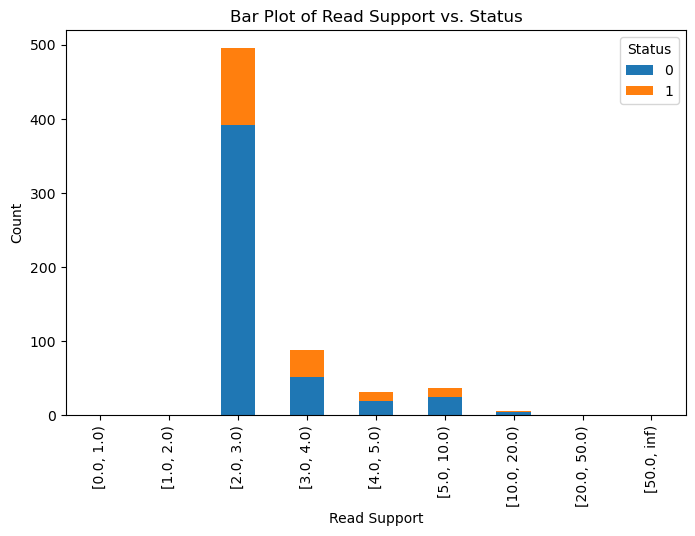

In [133]:
empDistFile = empDistFile_ad.copy()

bins = [0, 1, 2, 3, 4, 5, 10, 20,50, float('inf')]
empDistFile['ReadSupportBin'] = pd.cut(empDistFile['ReadSupport'], bins=bins, right=False)
grouped_empDist = empDistFile.groupby(['ReadSupportBin', 'Status']).size().unstack(fill_value=0)

# Plot the bar plot
ax = grouped_empDist.plot(kind='bar', stacked=True, figsize=(8, 5))

# Set labels and title
ax.set_xlabel('Read Support')
ax.set_ylabel('Count')
ax.set_title('Bar Plot of Read Support vs. Status')

# Show the plot
plt.show()

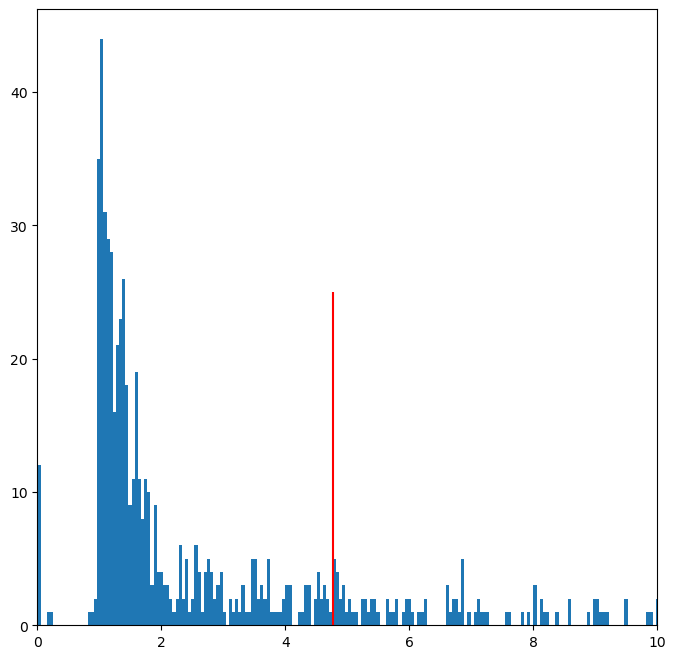

In [134]:
def getCutoff(summaryDF,quartile):
    q = f'{quartile}%'
    cutoff = pd.Series(summaryDF['mean']).describe()[q]
    return(cutoff)


empDistFile = empDistFile_neo.copy()

summary_empDist = empDistFile.filter(like="Sub").apply(lambda row: [np.mean(row), np.std(row)], axis=1, result_type='expand')
summary_empDist.columns = ['mean','sd']
empdistCutoff = getCutoff(summary_empDist,75)
p = plt.hist(summary_empDist['mean'],bins=5000)
plt.xlim(0,10)
plt.vlines(empdistCutoff, ymin = 0, ymax=25,colors="red")
plt.show()
empdistStatus = [1 if x else 0 for x in (summary_empDist['mean'] >= empdistCutoff)]

In [135]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "CoSim only" if v1 == 1 else "empDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(coSimFile_neo['Status'], empdistStatus)]

Text(0.5, 0.98, '3Sub2')

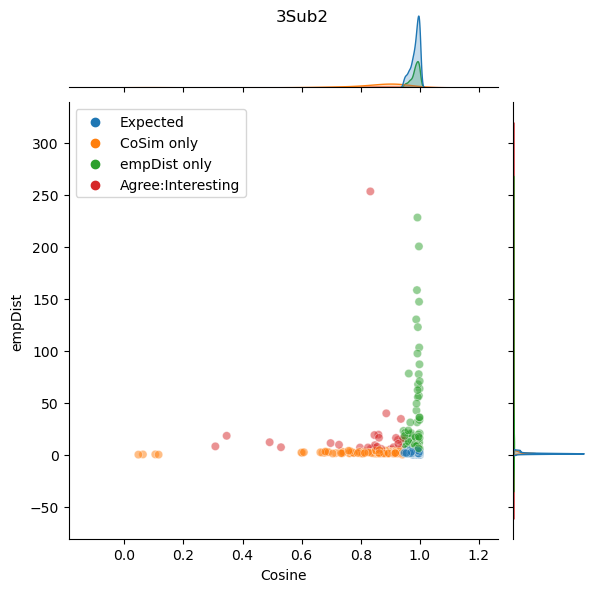

In [136]:
legend_order = ["Expected","CoSim only", "empDist only","Agree:Interesting"]

#plt.figure(figsize=(8, 4))
cos = coSimFile_neo['3Sub2']
empDist = empDistFile_neo['3Sub2']
j1 = sns.jointplot(x=cos, y=empDist, kind="scatter", 
                   hue=agreement_status, hue_order=legend_order, alpha = 0.5)
j1.set_axis_labels('Cosine', 'empDist', fontsize=10)
j1.fig.suptitle("3Sub2")
#axes[0].set_title('5Sub2')

In [137]:
with open(f'{dataDir}{runDir2}hyperEdges_neonatal_chr8.pkl','rb') as f:
    hpEdges = pickle.load(f)

print("Processing all the hyperedges from pickle file")
hpKeys = [k for k in hpEdges.keys()]
print("A total of",len(hpKeys),"initial interactions")

readSupport = [v for v in hpEdges.values()]
atLeastTwoChains = [i for i,x in enumerate(readSupport) if x >=2]
updatedDict = {hpKeys[i]:readSupport[i] for i in atLeastTwoChains}

hpKeys = [k for k in updatedDict.keys()]
hpKeys_split = [k.split("_") for k in updatedDict.keys()]
keyCard = [len(item) for item in hpKeys_split]


Processing all the hyperedges from pickle file
A total of 23736 initial interactions


In [138]:
print(len(agreement_status))
consensusIx = [coSimFile_neo['Edge_ix'][ix] for ix,x in enumerate(agreement_status) if x == "Agree:Interesting"]
print(len(consensusIx))
randList = random.sample(range(coSimFile_neo.shape[0]),len(consensusIx))

subsetKeys = [hpKeys[ix] for ix in consensusIx]
subsetKeyCard = [keyCard[ix] for ix in consensusIx]

689
31


In [126]:
import importlib
import chains
importlib.reload(chains)
import incidenceToProjection
importlib.reload(incidenceToProjection)

from chains import dictToDF
from incidenceToProjection import fillInGaps_realData, makeHiC_fromInc

In [139]:
subsetDict = {key: updatedDict[key] for key in subsetKeys}
subset_incDF = dictToDF(subsetDict)
finalBoundedScores = [finalBounded(list(subset_incDF[c])) for c in subset_incDF.columns]

In [140]:
rsubsetKeys = [hpKeys[ix] for ix in randList]
rsubsetKeyCard = [keyCard[ix] for ix in randList]
rsubsetDict = {key: updatedDict[key] for key in rsubsetKeys}
rsubset_incDF = dictToDF(rsubsetDict)

randomBoundedScores = [finalBounded(list(rsubset_incDF[c])) for c in rsubset_incDF.columns]

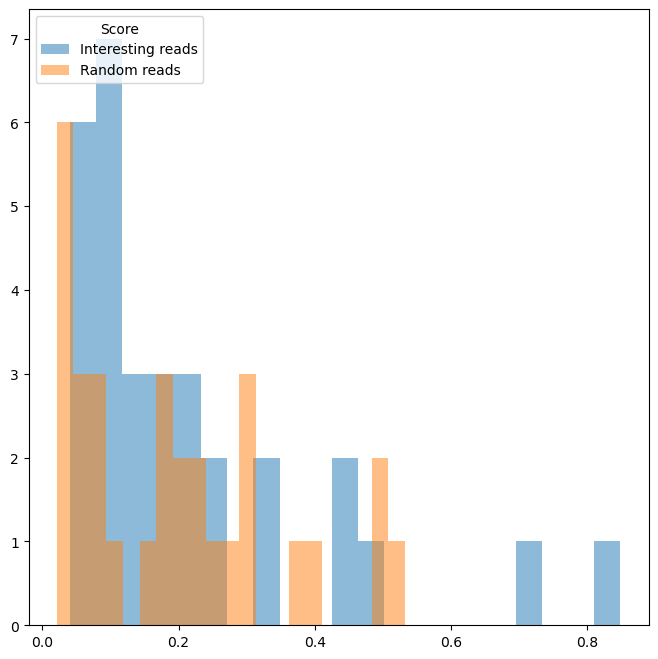

In [141]:
plt.hist(finalBoundedScores,bins = 21,alpha =0.5)
plt.hist(randomBoundedScores,bins = 21,alpha =0.5)
plt.legend(title="Score",loc="upper left",labels = ("Interesting reads","Random reads"))

In [142]:
fullDF = fillInGaps_realData(subset_incDF,"Bin",1)
projMat = makeHiC_fromInc(fullDF)

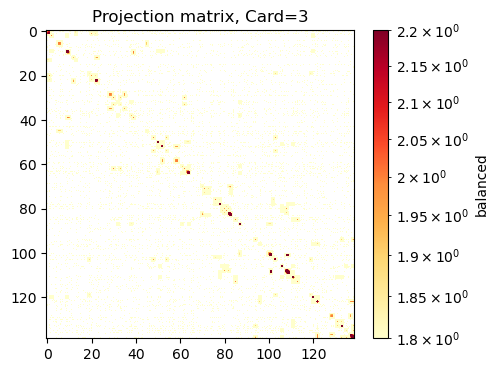

In [143]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm(vmax = 2))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}")
plt.show()

In [144]:
### Original matrix

ogDF = dictToDF(updatedDict)
ogProjMat = makeHiC_fromInc(ogDF)

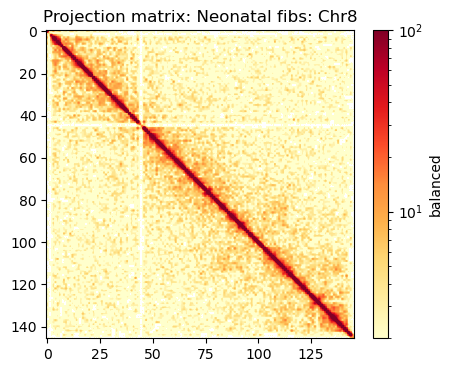

In [146]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(ogProjMat, cmap="YlOrRd",norm = LogNorm(vmax = 100))
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix: Neonatal fibs: Chr8")
plt.show()

In [147]:
import hypernetx as hnx
import networkx as nx

HIS = hnx.Hypergraph.from_incidence_dataframe(subset_incDF)
weights = pd.Series(finalBoundedScores, index = subset_incDF.columns)

for e in HIS.edges:
    HIS.edges[e].weight = weights[e]

# hnx.draw(HIS)

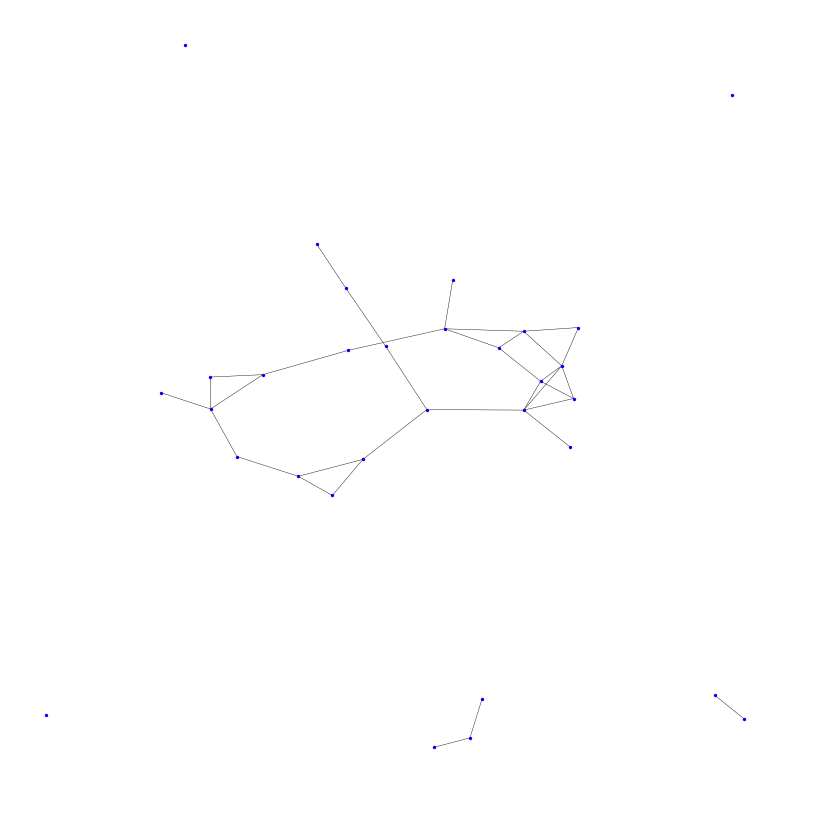

In [148]:
l = HIS.get_linegraph(s = 1)
nx.draw(l,node_size = 2, node_color = "blue",width = 0.3)

In [150]:
fullDF

,Read1:2,Read2:2,Read3:2,Read4:2,Read5:2,Read6:2,Read7:2,Read8:2,Read9:2,Read10:2,...,Read22:2,Read23:2,Read24:2,Read25:2,Read26:3,Read27:2,Read28:2,Read29:2,Read30:2,Read31:2
Bin3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Bin5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Bin8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bin43,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bin77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
